In [1]:
import os
import factorloader, utils
import stockdownload as dl
import evaluationtools as evaluate
import factorcombiner as cb
import numpy as np
import seaborn as sns
import pandas as pd

# 载入因子库

## 下载数据

In [2]:
code = "000012"
start = '2020-01-02'
end = '2023-07-31'
data = dl.download_domestic_index_data(code, start, end)
data

,date,open,close,high,low,volume,turnover,amplitude,quote change,change amount,turnover rate,symbol
0,2020-01-02,177.31,177.33,177.33,177.26,306995,2.974804e+08,0.04,0.03,0.06,0.0,000012
1,2020-01-03,177.34,177.33,177.34,177.32,307037,2.921772e+08,0.01,0.00,0.00,0.0,000012
2,2020-01-06,177.38,177.39,177.39,177.37,364200,3.596513e+08,0.01,0.03,0.06,0.0,000012
3,2020-01-07,177.41,177.41,177.42,177.39,271204,2.640021e+08,0.02,0.01,0.02,0.0,000012
4,2020-01-08,177.42,177.44,177.45,177.42,244236,2.354524e+08,0.02,0.02,0.03,0.0,000012
...,...,...,...,...,...,...,...,...,...,...,...,...
862,2023-07-25,203.42,203.28,203.42,203.27,33070031,3.326523e+10,0.07,-0.06,-0.13,0.0,000012
863,2023-07-26,203.30,203.31,203.32,203.29,45399216,4.561212e+10,0.01,0.01,0.03,0.0,000012
864,2023-07-27,203.32,203.39,203.39,203.32,47408201,4.768687e+10,0.03,0.04,0.08,0.0,000012
865,2023-07-28,203.41,203.38,203.43,203.36,32157146,3.233132e+10,0.03,0.00,-0.01,0.0,000012


In [3]:
# current working folder
CurrentFolder = os.getcwd()
# set files save paths
Factors_Folder_Path = CurrentFolder + '\\factorloader\\data\\' + str(code) + '\\'
Weights_Save_Path =  CurrentFolder + '\\factorcombiner\\data\\' + str(code) + '\\'
Factorsconcat_Name = 'factorsconcat.csv' 
Weight_Save_Name = 'weight.csv'
if not os.path.isdir(Factors_Folder_Path):
    os.makedirs(Factors_Folder_Path)
if not os.path.isdir(Weights_Save_Path):
    os.makedirs(Weights_Save_Path)

## 导入单因子

In [4]:
# check if factors currently exist
head = (start == str(pd.read_csv(Factors_Folder_Path + 'augur_0001.csv').iloc[0, 1]))
tail = (end == str(pd.read_csv(Factors_Folder_Path + 'augur_0001.csv').iloc[-1, 1]))
if not (head and tail):
    factorloader.all_main(code, start, end)

## 将预处理后的单因子组合成一张表

In [5]:
factor_date = data['date'][30:].reset_index()['date']
def pre(factor):
    # shift factor values to avoid using future data
    if len(factor.iloc[:, 1]):
        factor = factor.shift(1).fillna(factor.iloc[0, 1])
    
    # normalize first then standardize, its order changes new factor a lot
    f = utils.normalize(factor['factor'])
    f = utils.standardize(f)
    factor['factor'] = f

    # the initial factor always does not change or stays at 0 in the start,
    # to clean data, we pop the first 30 days value in the initial factor
    return factor.iloc[30:,:].reset_index(drop=True)

In [6]:
# save factors file paths list
os.chdir(Factors_Folder_Path)
file_list = os.listdir()
os.chdir(CurrentFolder)

# concat intialization: save the first factor
df = pd.read_csv(Factors_Folder_Path + file_list[0]).iloc[:, 1:3]
df = pre(df)
df = df.rename(columns={'factor': 'augur_001'})
df = df.iloc[:, 1]
df.to_csv(Weights_Save_Path +
          Factorsconcat_Name, encoding="utf_8_sig", index=False)

# concat other factors
file = [df]
for i in range(1, len(file_list)):
    f = pd.read_csv(Factors_Folder_Path + file_list[i]).iloc[:, 1:3]
    factor = pre(f)
    factor = factor.rename(columns={'factor': 'augur_00{}'.format(i+1)})
    if len(factor) == len(file[0]) and i != 40 and i != 43:
        file.append(factor.iloc[:, 1])
factor_combined = pd.concat(file, axis=1)
factor_combined.to_csv(Weights_Save_Path + Factorsconcat_Name,
                       encoding="utf_8_sig", index=False)
factor_combined

d:\nri_research\ts-market-timing\utils\preprocessing.py:73: RuntimeWarning: invalid value encountered in divide
  result = (np.array(s) - np.array(rolling_min)) / (np.array(rolling_max) - np.array(rolling_min))
d:\nri_research\ts-market-timing\utils\preprocessing.py:73: RuntimeWarning: invalid value encountered in divide
  result = (np.array(s) - np.array(rolling_min)) / (np.array(rolling_max) - np.array(rolling_min))
d:\nri_research\ts-market-timing\utils\preprocessing.py:73: RuntimeWarning: invalid value encountered in divide
  result = (np.array(s) - np.array(rolling_min)) / (np.array(rolling_max) - np.array(rolling_min))
d:\nri_research\ts-market-timing\utils\preprocessing.py:73: RuntimeWarning: invalid value encountered in divide
  result = (np.array(s) - np.array(rolling_min)) / (np.array(rolling_max) - np.array(rolling_min))
d:\nri_research\ts-market-timing\utils\preprocessing.py:50: RuntimeWarning: invalid value encountered in divide
  result = (np.array(s) - np.array(rolling_m

,augur_001,augur_002,augur_003,augur_004,augur_005,augur_006,augur_007,augur_008,augur_009,augur_0010,augur_0011,augur_0012,augur_0014,augur_0015,augur_0019,augur_0040,augur_0042,augur_0043
0,-0.911856,-0.110946,-0.110947,1.150656,0.842910,-3.271404,0.000000,1.202537,0.795223,0.045925,0.798434,0.877537,1.188034,0.984961,0.491014,0.000000,-0.290053,-0.331823
1,-0.527172,0.933123,0.933123,1.132225,0.819249,-2.038458,0.000000,1.054304,0.587321,0.208255,1.249165,1.053846,1.093449,1.102556,0.614854,0.000000,0.508756,-0.325821
2,-0.492887,0.197986,0.197986,1.003806,0.797493,-1.823935,0.000000,1.047264,0.313255,0.219667,1.470944,1.104339,1.118424,1.316811,0.517237,0.000000,0.043575,-0.320134
3,-0.410352,0.409181,0.409181,0.924984,0.777400,-1.547834,0.000000,1.086238,0.246737,0.613225,1.171484,0.989674,0.797082,1.261900,0.193605,0.000000,0.096740,-0.314736
4,1.150977,1.326905,1.326905,0.623622,0.284229,0.512716,0.000000,0.864493,0.857678,-0.279208,0.592403,0.819271,0.862278,1.142449,0.219444,0.000000,1.413144,-0.309603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,1.154389,-0.223931,-0.223931,-0.685114,-1.235548,0.452780,0.258886,2.275926,-0.686059,0.221918,2.079226,0.880575,1.287617,1.242818,1.260418,0.915995,0.009635,0.000000
833,-3.065501,-2.183174,-2.183174,3.068207,1.062546,-3.975687,0.258886,2.002703,2.893959,0.749423,2.114296,1.549779,1.533178,1.588235,1.616167,1.190720,0.348381,0.000000
834,-2.820902,-0.200332,-0.200332,2.904124,0.125006,-2.667425,0.258886,2.322300,3.673512,1.505915,2.743107,1.422632,1.828639,1.514603,1.343423,1.159032,-2.068319,0.000000
835,-1.620974,0.581956,0.581956,2.657207,-1.011047,-0.141603,0.258886,2.242606,3.220620,1.390991,2.185693,1.198012,1.345060,1.110337,1.207468,1.124508,-1.095659,0.000000


# 组合单因子

## 数据准备

### 因子跟踪对象

In [7]:
# calculate training target
y = dl.ret_rate(data, 1)

# select date: same as factor's date
y = utils.select_date(y, list(factor_date)[0], list(factor_date)[-1])

# combination
y = pd.DataFrame({'date': factor_date,
                   'ret': y['y']})
y

,date,ret
0,2020-02-21,0.000840
1,2020-02-24,0.000056
2,2020-02-25,0.000168
3,2020-02-26,0.002292
4,2020-02-27,0.000614
...,...,...
832,2023-07-25,-0.000639
833,2023-07-26,0.000148
834,2023-07-27,0.000393
835,2023-07-28,-0.000049


### 筛选因子

In [8]:
train_size = 0.8
selected_col_list = cb.select(factor_combined, y, train_size, num=10)
factor_selected = factor_combined[selected_col_list]
factor_selected

,augur_006,augur_007,augur_001,augur_0043,augur_0040,augur_0042,augur_003,augur_002,augur_0010,augur_009
0,-3.271404,0.000000,-0.911856,-0.331823,0.000000,-0.290053,-0.110947,-0.110946,0.045925,0.795223
1,-2.038458,0.000000,-0.527172,-0.325821,0.000000,0.508756,0.933123,0.933123,0.208255,0.587321
2,-1.823935,0.000000,-0.492887,-0.320134,0.000000,0.043575,0.197986,0.197986,0.219667,0.313255
3,-1.547834,0.000000,-0.410352,-0.314736,0.000000,0.096740,0.409181,0.409181,0.613225,0.246737
4,0.512716,0.000000,1.150977,-0.309603,0.000000,1.413144,1.326905,1.326905,-0.279208,0.857678
...,...,...,...,...,...,...,...,...,...,...
832,0.452780,0.258886,1.154389,0.000000,0.915995,0.009635,-0.223931,-0.223931,0.221918,-0.686059
833,-3.975687,0.258886,-3.065501,0.000000,1.190720,0.348381,-2.183174,-2.183174,0.749423,2.893959
834,-2.667425,0.258886,-2.820902,0.000000,1.159032,-2.068319,-0.200332,-0.200332,1.505915,3.673512
835,-0.141603,0.258886,-1.620974,0.000000,1.124508,-1.095659,0.581956,0.581956,1.390991,3.220620


## 开始组合

In [9]:
CombineEngine = cb.LinearCombine(factor_selected.shape[1])
weight, new_factor = CombineEngine.train_new_expr(y, factor_selected, train_size)
new_factor = pd.DataFrame({'date': factor_date,
                           'factor': new_factor})
new_factor

Iteration times: 785


,date,factor
0,2020-02-21,-0.243462
1,2020-02-24,-0.142601
2,2020-02-25,-0.128683
3,2020-02-26,-0.120936
4,2020-02-27,0.041646
...,...,...
832,2023-07-25,0.091300
833,2023-07-26,-0.529757
834,2023-07-27,-0.318828
835,2023-07-28,-0.115032


## 保存权重值

In [10]:
pd.DataFrame(weight).to_csv(Weights_Save_Path +
          Weight_Save_Name, encoding="utf_8_sig", index=False)
weight

array([ 0.07027592,  0.01301148,  0.00770848, -0.06988058,  0.04353629,
       -0.04396051,  0.02236515,  0.02236407, -0.05576693, -0.04394671])

# 评估

## IC 检测

-0.010614280635777611

<Figure size 640x500 with 0 Axes>

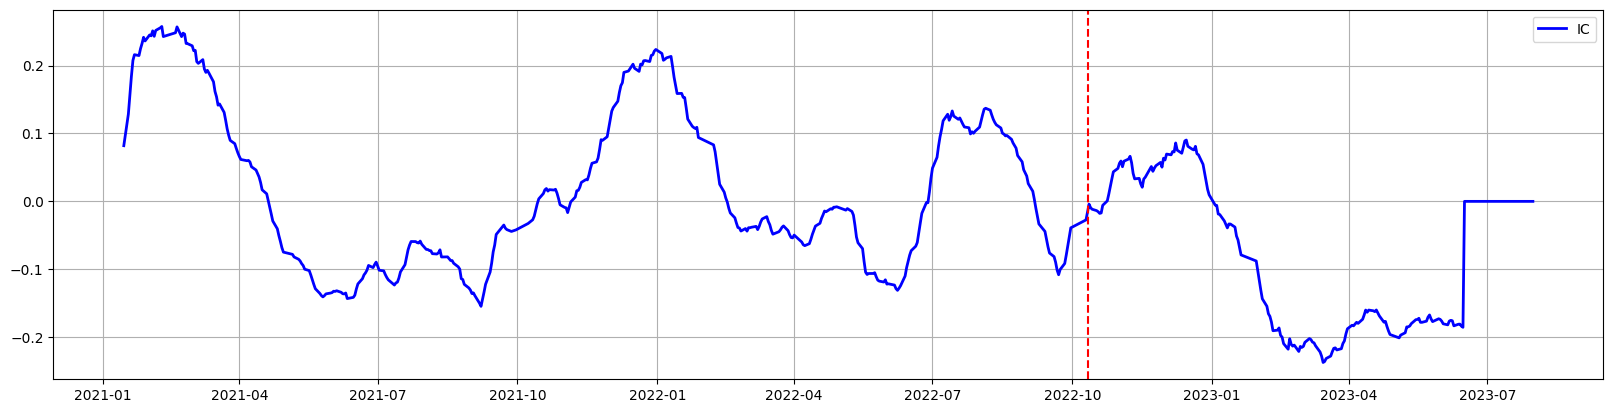

In [11]:
ic = evaluate.ic_test(data, new_factor, win = 252, plot=True, train_length = int(len(new_factor)*train_size)) # 计算IC统计量
ic.mean()

## 因子回测

In [12]:
bound = evaluate.cal_bound(new_factor, switch='rolling', train_size=train_size)

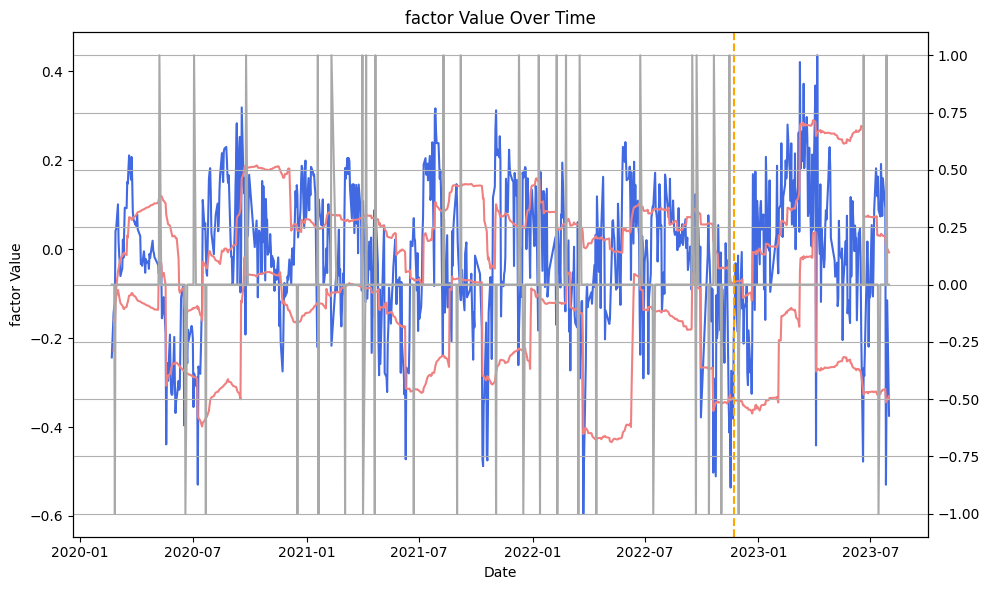

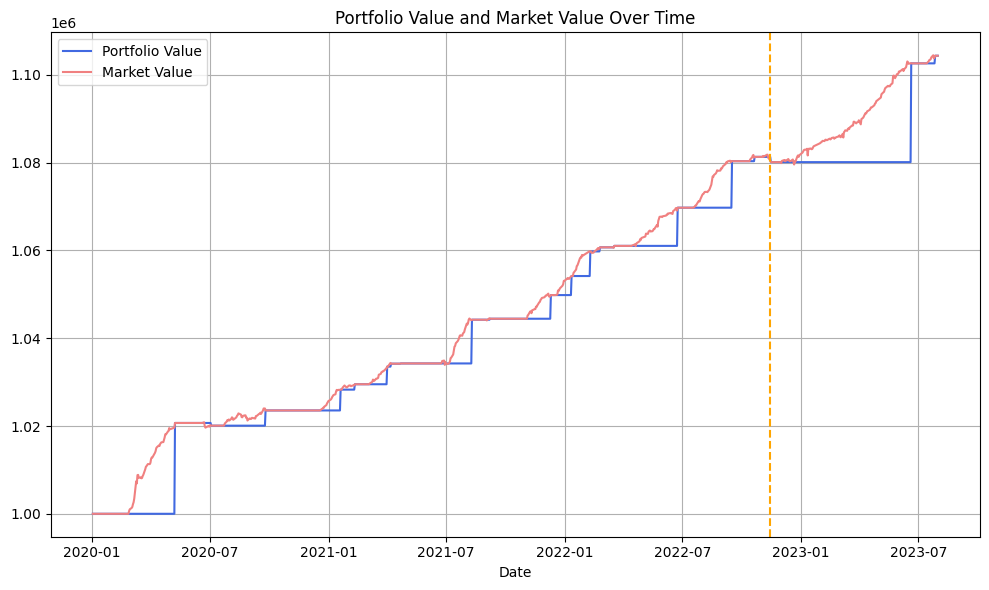

--- Portfolio Summary ---
Cash: 1104379.0724419004
Positions:
000012: 0.0
--- Performance Metrics ---
Total Returns: 10.44%
Annualized Returns: 2.93%
Volatility: 1.90%
Sharpe Ratio: 0.49
Total P&L: 401.57
Average Trade Return: 0.30%
Win Ratio: 53.49%


In [13]:
# sell signal: -1, buy signal: 1
annual_ret = evaluate.backtest_main(data, new_factor, bound, upperbound = 'buy', plot=True, train_size=train_size)

## 分层分析

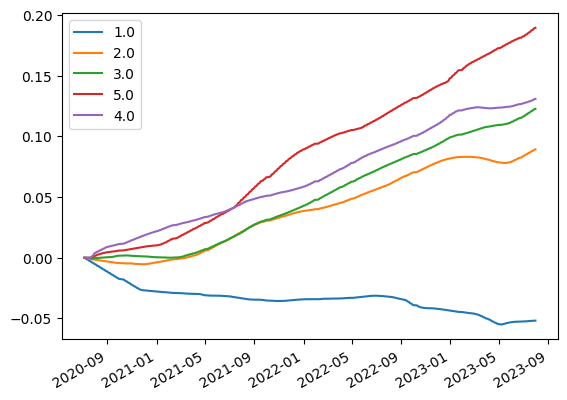

In [14]:
engine = evaluate.LayeredBacktestingEngine(data, new_factor, window=90, n_group=5, ret_period=1)
cret_group = engine.cal_roll_res_list()
cret_group.plot.line()
evaluate.plt.show()